# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`,
2. Upload an text file as `SOURCE_POINTS_FILE`,
3. Upload an text file as `TARGET_POINTS_FILE`, and
4. Run `rectify()` and show the output image.


In [0]:
"""
Author: shyyhs
Github repo: https://github.com/shyyhs/Computer-Vision

Photos by shyyhs.
"""

import numpy as np
from copy import copy
import cv2
from math import *
import matplotlib.pyplot as plt
from google.colab import files

#assistant function
f=[lambda a:floor(a),lambda a:ceil(a)]
#calculate the target point from the original point through H (PPT 24)
calPoint=lambda x,y,H:[(H[i][0]*x+H[i][1]*y+H[i][2])/(H[2][0]*x+H[2][1]*y+H[2][2]) for i in range(2)]
#cross product
cross=lambda p1,p2,p0: (p1[1]-p0[1])*(p2[0]-p0[0])-(p1[0]-p0[0])*(p2[1]-p0[1])
#distance from point to point(distPP) and from point to vecter(distPL)
distPP = lambda p1,p2:sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
distPL = lambda x,y,conv: min([cross(conv[(i+1)%conv.shape[0]],[x,y],conv[i])/distPP(conv[(i+1)%conv.shape[0]],conv[i]) for i in range(conv.shape[0])])

In [0]:
def build_A(pts1, pts2):
    """Constructs the intermediate matrix A used in the computation of an
    homography mapping pts1 to pts2."""
    # Build and return A. from pts1 and pts2
    A = np.zeros((2*np.array(pts1).shape[0],3*3),dtype=np.float32)
    for points in range(np.array(pts1).shape[0]):
        row_index = points*2
        A[row_index][0:3]=A[row_index+1][3:6]=A[row_index][6:]=A[row_index+1][6:]=[pts1[points][0],pts1[points][1],1.0]
        for plusline in range(2):
            A[row_index+plusline][6:]*=(-pts2[points][plusline])
    return A

In [0]:
def compute_H(pts1, pts2):
    """Computes an homography mapping one set of co-planar points (pts1) to another (pts2)."""
    # Construct the intermediate A matrix and compute the eigenvalues of AtA
    A = build_A(pts1,pts2) 
    evalue,evector = np.linalg.eig(np.matmul(A.T,A))
    evalue=[abs(x) for x in evalue]
    # Return the eigenvector corresponding to the smallest eigenvalue, reshaped as a 3x3 matrix.
    return np.array(evector[:,evalue.index(min(evalue))]).reshape(3,3)

In [0]:
#Take four points from image and combine them into the color of (x,y) in the targetImage by using h_Reverse
def pointColor(x,y,hR,image):
    [exactX,exactY]=calPoint(x,y,hR)
    if (exactX<=0 or exactY<=0 or exactX>=image.shape[0]-1 or exactY>=image.shape[1]-1):
        return (np.array([0,0,0]))
    #The adjacent points are saved in adjP and the fraction of each point is saved in adjF
    adjP=[[fx(exactX),fy(exactY)] for fx in f for fy in f]
    adjF=[(1-abs(adjpoint[0]-exactX))*(1-abs(adjpoint[1]-exactY)) for adjpoint in adjP]
    col=[int(round(c)) for c in sum([image[adjP[i][0],adjP[i][1]]*adjF[i] for i in range(4)])]
    return (np.array(col))

In [0]:
# Compute the rectifying homography that warps the planar points to the target rectangular region.
def rectify(image, pts1, pts2):
    h=compute_H(pts1,pts2); hR=compute_H(pts2,pts1);
    # Find the four corners of the target image and calculate the leftTop and rightBottom corners.
    cornerP=[calPoint(i,j,h) for i in[0,image.shape[0]] for j in[0,image.shape[1]]]
    minCorner=([trunc(min([x[i] for x in cornerP])) for i in range(2)])
    maxCorner=([trunc(max([x[i] for x in cornerP])) for i in range(2)])
     # Perform inverse warping and return the result.
    E=np.array([[pointColor(i,j,hR,image) for j in range(minCorner[1],maxCorner[1])] for i in range(minCorner[0],maxCorner[0])]).astype(np.uint8)
    return  ([E,minCorner])

In [0]:
# colaboratory-specific helper functions
def upload_sub(msg):
    print(msg)
    f = files.upload()
    if bool(f) is False:
        return None
    fname = list(f.keys())[0]
    return fname

def upload(msg):
    f = None
    while f is None:
        f = upload_sub(msg)
    return f

## Step 1-1: Upload `IMAGE`

IMAGE:


Saving osakaSmall.png to osakaSmall.png


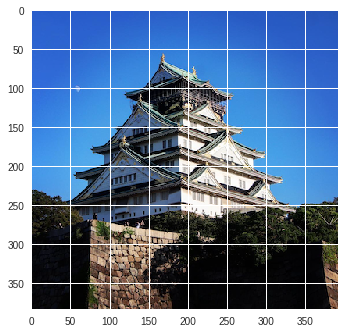

In [10]:
image = cv2.imread(upload('IMAGE:'), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [11]:
pts1 = np.loadtxt(upload('SOURCE_POINTS_FILE:'))
print(pts1)

SOURCE_POINTS_FILE:


Saving point1_osakaSmall.txt to point1_osakaSmall.txt
[[ 86. 193.]
 [122. 334.]
 [220. 193.]
 [256. 334.]]


## Step 1-3:  TARGET_POINTS_FILE

In [12]:
pts2 = np.loadtxt(upload('TARGET_POINTS_FILE:'))
print(pts2)

TARGET_POINTS_FILE:


Saving point2_osakaSmall.txt to point2_osakaSmall.txt
[[ 86. 193.]
 [ 86. 334.]
 [220. 193.]
 [220. 334.]]


## Step 1-4: Rectify

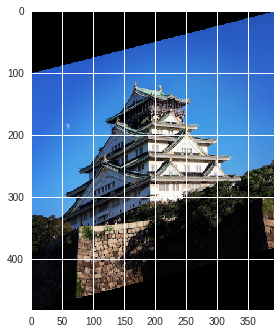

In [13]:
[rectified , offset] = rectify(image, pts1, pts2)
plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [0]:
#Mask the point near the boundary of a convex hull(defined by target_pts). WARNING: THIS MAY NOT WORK WHEN target_pts IS NOT A CONVEX HULL.
def mask(target,i,j,rectified,offset,target_pts):
    dist=distPL(i,j,target_pts)
    fra = 1 if (dist<-5) else (0 if dist>5 else (-dist*0.1+0.5))
    return [fra*target[i][j][k]+(1-fra)*rectified[i-offset[0]][j-offset[1]][k] for k in range(3)]

In [0]:
def composite(source, target, source_pts, target_pts):
    """Paint part of the source image on targetImage, mask the boundary(which is automatically detected by mask function)"""
    # Warp the images using the homography.
    [rectified , offset] = rectify(source, source_pts, target_pts)
    #Calculate the color in each point in target image, masking automatically occur which is defined in mask()
    for i in range(offset[0],offset[0]+rectified.shape[0]):
        for j in range(offset[1],offset[1]+rectified.shape[1]):
            target[i][j]=mask(target,i,j,rectified,offset,target_pts);
    return target

## Step 2-1: Upload `SOURCE` image

SOURCE:


Saving osakaSmall.png to osakaSmall (1).png


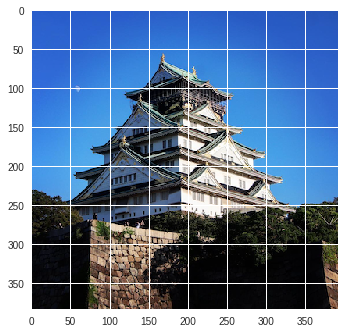

In [16]:
import cv2
source = cv2.imread(upload('SOURCE:'), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

## Step 2-2: Upload `TARGET` image

TARGET:


Saving selfsmall.png to selfsmall.png


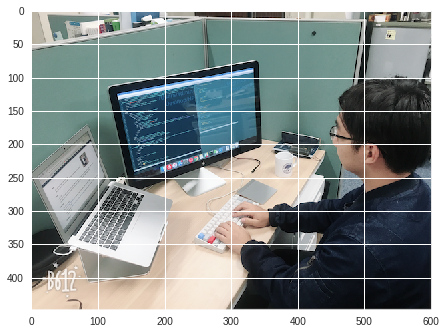

In [17]:
target = cv2.imread(upload('TARGET:'), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [18]:
#source_pts = np.loadtxt(upload('SOURCE_POINTS_FILE:'))
source_pts=[[0,0],[0,source.shape[1]],[source.shape[0],source.shape[1]],[source.shape[0],0]]
print(source_pts)

[[0, 0], [0, 393], [383, 393], [383, 0]]


## Step 2-4: Upload `TARGET_POINTS` file

In [19]:
target_pts = np.loadtxt(upload('TARGET_POINTS_FILE:'))
print(target_pts)

TARGET_POINTS_FILE:


Saving point1.txt to point1.txt
[[125. 129.]
 [ 86. 333.]
 [197. 337.]
 [257. 157.]]


## Step 2-5: Upload `MASK` image (The mask is calculated)

## Step 2-6: Composite

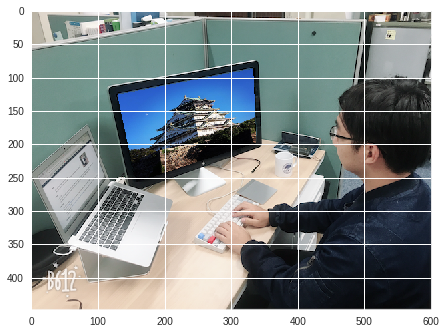

In [33]:
composited = composite(source, target, source_pts, target_pts).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))

# Temple codes for debugging

In [0]:
#@title
#Test the function of build_A
#pts1 = np.array([[0,0],[1,0],[1,1],[0,1]]).astype(np.float32)
#pts2 = np.array([[1,0],[2,0],[2,1],[1,1]]).astype(np.float32)
#First construct the elements of one pair of point. Then connect them together.
#pts1[4][2] pts1[i][0]==xi pts1[i][1]==yi
#pts2[4][2] pts2[i][0]==xi' pts2[i][1]==yi'

"""
print(pts1);
print(pts2);
A = np.zeros((2*np.array(pts1).shape[0],3*3),dtype=np.float32)
for points in range(np.array(pts1).shape[0]):
    row_index = points*2
    A[row_index][0:3]=A[row_index+1][3:6]=A[row_index][6:]=A[row_index+1][6:]=[pts1[points][0],pts1[points][1],1.0]
    for plusline in range(2):
        A[row_index+plusline][6:]*=(-pts2[points][plusline])
print (A)
"""

In [0]:
#@title
#Test the function compute_H
#print (np.matmul(A,A.T))
"""
AtA = np.matmul(A.T,A)
evalue,evector = np.linalg.eig(AtA)
index=0;
for i in range(evalue.shape[0]):
    if (abs(evalue[index])>abs(evalue[i])):
        index=i;
E=np.array([evector[i][index] for i in range(evector.shape[0])],dtype='float32').reshape(3,3);
"""

In [0]:
"""
hR=compute_H(pts2,pts1);
[exactX,exactY]=calPoint(100,100,hR)
if (exactX==0 or exactY==0 or exactX>=image.shape[0]-1 or exactY>=image.shape[1]-1):
    print (np.array([0,0,0]))
adjP=[[fx(exactX),fy(exactY)] for fx in f for fy in f]
adjF=[(1-abs(adjpoint[0]-exactX))*(1-abs(adjpoint[1]-exactY)) for adjpoint in adjP]
col=[int(round(c)) for c in sum([image[adjP[i][0],adjP[i][1]]*adjF[i] for i in range(4)])]
print (np.array(col))
print(image[int(exactX)][int(exactY)])
"""

In [0]:
def bilinear_interp(image, points):
    """Looks up the pixel values in an image at a given point using bilinear
    interpolation."""
    # Compute the four integer corner coordinates (top-left/right,
    # bottom-left/right) for interpolation, as well as the fractional part of
    # the coordinates.

    # Interpolate between the top two pixels.

    # Interpolate between the bottom two pixels.

    # Return the result of the final interpolation between top and bottom.


In [0]:
def warp_homography(source, target_shape, Hinv):
    """Warp the source image into the target coordinate frame using a provided
    inverse homography transformation."""
    # NOTE: This can be done much more efficiently (>10x faster) in Python
    # using a series of numpy array operations as opposed to a for loop.

    # Hints for fast version:
    # * Read about numpy broadcasting rules and reshaping operations.
    # * Look up numpy.mgrid / meshgrid for tips on how to quickly generate an
    #   array containing coordinates of all of the points in an image.
    # * You can modify your bilinear_interp() function to take an array of
    #   points instead of single points. Express the actions in this function
    #   using the aforementioned array operations.

    # Warp the source image to the corresponding coordinate system in the
    # output image by:
    #     * transforming points in the output image to the source image space (using the homography)
    #     * looking up pixel values in the source image at the transformed points (using bilinear interpolation)

    # Return the output image

In [0]:
#check whether a point in a convex hull
x=conv[3][0]+1;
y=conv[3][1];
conv=copy(target_pts);
print(conv)
def inCheck(x,y,conv):
    return all([cross(conv[(i+1)%conv.shape[0]],[x,y],conv[i])>=0 for i in range(conv.shape[0])])
print (inHull(x,y,conv))

In [0]:
def blend_with_mask(source, target, mask):
    """Blends the source image with the target image according to the mask.
    Pixels with value "1" are source pixels, "0" are target pixels, and
    intermediate values are interpolated linearly between the two."""
    
    
# Just in case you want to download the output

# cv2.imwrite("rectified.png", rectified)
# files.download('rectified.png')

In [0]:
#mask = cv2.imread(upload('MASK:'), cv2.IMREAD_GRAYSCALE)
mask=copy(source)
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]
print(mask.shape)

In [0]:
target_pts=[[0,0],[10,0],[10,10],[0,10]]
i=1; j=1;
C=abs(cross(target_pts[1],[i,j],target_pts[0])/dist(target_pts[1],target_pts[0]))
distPP = lambda p1,p2:sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
distPL = lambda x,y,conv: ([cross(conv[(i+1)%conv.shape[0]],[x,y],conv[i])/dist(conv[(i+1)%conv.shape[0]],conv[i]) for i in range(conv.shape[0])])
print (distPL(i,j,np.array(target_pts)))

[-1.0, -9.0, -9.0, -1.0]
